This file contains python code to check the hypothesis testing

In [1]:
import sys
sys.path.append("../mypkg")

In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from numbers import Number
import multiprocessing as mp

from easydict import EasyDict as edict
from tqdm import trange
from scipy.io import loadmat
from pprint import pprint


/opt/conda/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
import importlib
import optimization.one_step_opt
importlib.reload(optimization.one_step_opt)
import optimization.opt
importlib.reload(optimization.opt)

<module 'optimization.opt' from '/data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/../mypkg/optimization/opt.py'>

In [4]:
from constants import DATA_ROOT, RES_ROOT, FIG_ROOT, MIDRES_ROOT
from default_paras import def_paras

from hdf_utils.data_gen import gen_covs, gen_simu_psd, gen_simu_ts
from hdf_utils.fns import fn1, fn2, fn3, fn4, fn5, zero_fn
from hdf_utils.fns_sinica import coef_fn, fourier_basis_fn
from hdf_utils.likelihood import obt_lin_tm
from hdf_utils.SIS import SIS_linear
from utils.matrix import col_vec_fn, col_vec2mat_fn, conju_grad, svd_inverse
from utils.functions import logit_fn
from utils.misc import save_pkl, load_pkl
from splines import obt_bsp_basis_Rfn, obt_bsp_basis_Rfn_wrapper
from projection import euclidean_proj_l1ball
from optimization.one_step_opt import OneStepOpt
from optimization.cross_validation import CV_err_linear_fn
from optimization.opt import optimization
from penalties.scad_pen import SCAD
from models.linear_model import LinearModel

from joblib import Parallel, delayed

In [5]:
plt.style.use(FIG_ROOT/"base.mplstyle")

In [6]:
torch.set_default_tensor_type(torch.DoubleTensor)

# Param and fns

## Params

In [96]:
np.random.seed(0)
paras = edict(def_paras.copy())

# Others
paras.num_rep = 100 
paras.freqs = np.linspace(2, 45, 40) # freqs
paras.init_noise_sd = 2 # the sd of the noise added to the true value for initial values
paras.SIS_ratio = 1 # the ratio to keep with SIS procedure
#paras.SIS_ratio = 0.3 # the ratio to keep with SIS procedure
paras.svdinv_eps_Q = 1
paras.svdinv_eps_Psi = 1

# multiple sets of params
paras.ns = [100, 300, 900, 2700, 8100, 24300]
paras.can_lams = [1e-1, 3e-1, 1e0, 3e0, 9e0, 3e1]
paras.can_Ns = [5, 10, 15, 20]

# generating dataset
paras.n = 100 # num of data obs to be genareted
paras.npts = 40 # num of pts to evaluate X(s)
paras.d = 20 # num of ROIs
paras.q = 5 # num of other covariates
paras.sigma2 = 0.1 # variance of the error
paras.types_ = ["int", 2, 2, "c", "c"]

# b-spline
paras.N = 16 # int(3*paras.n**(1/paras.ord/2)) # num of basis for bsp
paras.x = np.linspace(0, 1, paras.npts)
paras.basis_mat = torch.tensor(obt_bsp_basis_Rfn_wrapper(paras.x, paras.N, paras.ord)).to(torch.get_default_dtype())
assert paras.N == paras.basis_mat.shape[1]
print(f"The number of B-spline basis is {paras.N:.0f}.")

# True parameters
paras.alp_GT = np.array([5, 1, -2, 3, -4])

# first way
#beta_type_GT = [fn1, fn2, fn2] + [zero_fn]*(paras.d-3-2) + [fn1, fn2]
#paras.beta_GT = np.array([_fn(paras.x) for _fn in beta_type_GT]).T
# second way, fourier basis
paras.fourier_basis = fourier_basis_fn(paras.x)
#paras.fourier_basis_coefs = ([coef_fn(0.1), coef_fn(0.3), coef_fn(0.5)] + 
#                             [np.zeros(50)] * (paras.d-3-2) +
#                             [coef_fn(0.7), coef_fn(0.9)]
#                             )
paras.fourier_basis_coefs = ([np.zeros(50)] * (paras.d-2) +
                             [coef_fn(0.7), coef_fn(0.9)]
                             )
paras.fourier_basis_coefs = np.array(paras.fourier_basis_coefs).T * 5
paras.beta_GT = paras.fourier_basis @ paras.fourier_basis_coefs #* 10
#
paras.Gam_GT_est = (np.linalg.inv(paras.basis_mat.numpy().T 
                               @ paras.basis_mat.numpy()) 
                               @ paras.basis_mat.numpy().T 
                               @ paras.beta_GT)

# optimization
paras.Rmin = 2*(np.linalg.norm(paras.Gam_GT_est/np.sqrt(paras.N), axis=0).sum() + np.abs(paras.alp_GT).sum())
paras.sel_idx = np.arange(1, paras.d) # M^c set, 
#without loss of generality, we assume the idxs in M is the first m betas
paras.num_cv_fold = 5
paras.Rfct = 2
#paras.stop_cv = 5e-5
paras.stop_cv = 5e-4
#paras.max_iter = 10000
paras.max_iter = 2000

# hypothesis test
paras.M_idxs = np.delete(np.arange(paras.d), paras.sel_idx) # the M set
paras.Cmat = np.eye(len(paras.M_idxs)) # Cmat \times beta_M(s), r x m
paras.r, paras.m = paras.Cmat.shape
paras.t_vec = np.zeros(paras.Cmat.shape[0]) # t vec, typically it is zero vector


The number of B-spline basis is 16.


In [46]:
paras.save_dir = RES_ROOT/"linear_test"
if not paras.save_dir.exists():
    paras.save_dir.mkdir()

## Fns

In [47]:
from scipy.stats import gaussian_kde
def _plot_kde(data, label=None):
    """Due to the error in sns.kdeplot
    """
    kde = gaussian_kde(data)
    x = np.linspace(min(data), max(data), 100)
    plt.plot(x, kde(x), label=label)

In [48]:
def MS2idxs(q, N, MS_unions):
    """This fn is to return the idxs to keep in mat Q, Sigma and vec Theta
    """
    idxs_all = [np.arange(0, q)]
    for cur_idx in MS_unions:
        idxs_all.append(np.arange(q+cur_idx*N, q+(cur_idx+1)*N))
    idxs_all = np.concatenate(idxs_all)
    return idxs_all

In [49]:
def get_Amat(k, paras):
    """Get A matrix for hypothesis test
        k: Num of elements in S
        paras: parameters
                required: N, Cmat, m, q
    """
    _paras = edict(paras.copy())
    
    part1 = np.kron(_paras.Cmat, np.eye(_paras.N))
    part2 = np.zeros((_paras.m*_paras.N, _paras.q+(_paras.m+k)*_paras.N))
    part2[:, _paras.q:(_paras.q+_paras.m*_paras.N)] = np.eye(_paras.m*_paras.N)
    A = part1 @ part2
    return A

In [104]:
def _is_exists(d, n, seed):
    """
    Check if a file with the given parameters exists.

    Args:
    d (int): The value of d in the file name.
    n (int): The value of n in the file name.
    seed (int): The seed value in the file name.

    Returns:
    bool or Path: Returns the file path if the file exists, otherwise returns False.
    """
    _get_n = lambda fil: int(fil.stem.split("-")[-1])
    fils = MIDRES_ROOT.glob(f"PSD_d-{d}_n*")
    # We do not need fil with n as we know the data with corresponding seed does not exist
    fils = [fil for fil in fils if _get_n(fil) !=n]
    if len(fils) == 0:
        return False
    else:
        fils = sorted(fils, key=_get_n)
        ns = np.array([_get_n(fil) for fil in fils])
        idxs = np.where(n <= ns)[0]
        if len(idxs) == 0:
            return False
        else:
            fil =fils[idxs[0]]
            path = MIDRES_ROOT/fil/f"seed_{seed}.pkl"
            return path if path.exists() else False
def _get_filename(params):
    keys = ["d", "n"]
    folder_name = 'PSD_'+'_'.join(f"{k}-{params[k]}" for k in keys)
    return folder_name + f'/seed_{params.seed}.pkl'
def _gen_simu_data_all(seed, paras, verbose=False, is_gen=False):
    """
    Generate simulated data for all parameters.

    Args:
        seed (int): Seed for random number generator.
        paras (dict): Dictionary containing the following parameters:
            - n (int): Number of samples.
            - d (int): Number of dimensions.
            - q (int): Number of covariates.
            - types_ (list): List of types for generating covariates.
            - alp_GT (list): List of ground truth alpha values.
            - beta_GT (list): List of ground truth beta values.
            - freqs (list): List of frequencies for generating simulated PSD.
            - sigma2 (float): Variance of the noise.
        verbose(bool): Verbose or not
        is_gen(bool): Only for generating or not. If True, only checking or generating X, not return anything.

    Returns:
        all_data (dict): Dictionary containing the following simulated data:
            - X (torch.Tensor): Tensor of shape (n, d, npts) containing the simulated PSD.
            - Y (torch.Tensor): Tensor of shape (n,) containing the response variable.
            - Z (torch.Tensor): Tensor of shape (n, q) containing the covariates.
    """
    np.random.seed(seed)
    _paras = edict(paras.copy())
    # simulated PSD
    assert len(_paras.types_) == _paras.q
    assert len(_paras.alp_GT) == _paras.q
    tmp_paras = edict()
    tmp_paras.seed = seed 
    tmp_paras.n = _paras.n
    tmp_paras.d = _paras.d
    
    file_path = MIDRES_ROOT/_get_filename(tmp_paras)
    if file_path.exists():
        if is_gen:
            return None
        simu_curvs = load_pkl(file_path, verbose=verbose)
    else:
        ofil =  _is_exists(_paras.d, _paras.n, seed)
        if ofil:
            if is_gen:
                return None
            simu_curvs = load_pkl(ofil, verbose=verbose)
        else:
            simu_curvs = gen_simu_psd(_paras.n, _paras.d, _paras.freqs, prior_sd=10, n_jobs=20, is_prog=False)
            save_pkl(file_path, simu_curvs, verbose=verbose)
    if is_gen:
        return None
    #simu_curvs = simu_curvs[:_paras.n]
    simu_curvs = np.random.randn(_paras.n, _paras.d, _paras.npts) * 10
    simu_curvs = simu_curvs + np.random.randn(*simu_curvs.shape)*0.2
    simu_covs = gen_covs(_paras.n, _paras.types_)
    
    # linear term and Y
    int_part = np.sum(_paras.beta_GT.T* simu_curvs[:, :, :], axis=1).mean(axis=1)
    cov_part = simu_covs @ _paras.alp_GT 
    
    # linear term
    lin_term = cov_part + int_part
    
    # Y 
    rvs = np.random.rand(_paras.n)
    Y = lin_term + np.random.randn(_paras.n)*np.sqrt(_paras.sigma2)
    
    # To torch
    X = torch.Tensor(simu_curvs) # n x d x npts
    Z = torch.Tensor(simu_covs) # n x q
    Y = torch.Tensor(Y)
    
    all_data = edict()
    all_data.X = X
    all_data.Y = Y
    all_data.Z = Z
    all_data.lin_term = lin_term
    return all_data

In [51]:
def obt_test_stat(model, est_alp, est_Gam, paras):
    """
    Obtain the test statistics via the estimator.

    Args:
        model: The model you used, LinearModel or LogisticModel
        est_alp: Estimated alp parameters
        est_Gam: Estimated Gam parameters
        paras: Dictionary containing parameters for the test
            - N: Number of samples
            - M_idxs: Indices of the M set
            - q: Number of ROIs
            - svdinv_eps_Q: Threshold for SVD inverse of Q matrix
            - svdinv_eps_Psi: Threshold for SVD inverse of Psi matrix
            - n: Number of observations

    Returns:
        T_v: Test statistic value
    """
    _paras = edict(paras.copy())
    est_theta = torch.cat([est_alp, col_vec_fn(est_Gam)/np.sqrt(_paras.N)])
    Q_mat = -model.log_lik_der2(est_alp, est_Gam)
    model.log_lik_der1(est_alp, est_Gam);
    Sig_mat = (model.log_lik_der1_vs.unsqueeze(-1) * model.log_lik_der1_vs.unsqueeze(1)).mean(axis=0) 
    # minus sign canceled
    
    
    # obtain the idxs to keep for test
    nonzero_idxs = torch.nonzero(torch.norm(est_Gam, dim=0)).reshape(-1).numpy()
    MS_unions = np.sort(np.union1d(_paras.M_idxs, nonzero_idxs))
    keep_idxs_test = MS2idxs(_paras.q, _paras.N, MS_unions)
    
    # A mat
    k = len(np.setdiff1d(nonzero_idxs, _paras.M_idxs))
    Amat = torch.Tensor(get_Amat(k, _paras))
    
    # calculate Test stats
    Q_mat_part = Q_mat[keep_idxs_test][:, keep_idxs_test]
    if _paras.svdinv_eps_Q >= 1:
        Q_mat_part_inv = torch.pinverse(Q_mat_part)
    else:
        Q_mat_part_inv = svd_inverse(Q_mat_part, _paras.svdinv_eps_Q)
    
    Sig_mat_part = Sig_mat[keep_idxs_test][:, keep_idxs_test]
    Psi = Amat @ Q_mat_part_inv @ Sig_mat_part @ Q_mat_part_inv @ Amat.T
    
    T_p1 = Amat @ est_theta[keep_idxs_test]
    if _paras.svdinv_eps_Psi >= 1:
        Psi_inv = torch.pinverse(Psi)
    else:
        Psi_inv = svd_inverse(Psi, _paras.svdinv_eps_Psi)
    T_v = T_p1 @ Psi_inv @ T_p1 * _paras.n 
    return T_v

# Simu

## Generate data
To avoid nested joblib

In [14]:
for seed in trange(paras.num_rep):
    _gen_simu_data_all(seed, paras, is_gen=True)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 976.05it/s]


## Simulation

In [97]:
def _run_fn(seed, lam):
    torch.set_default_tensor_type(torch.DoubleTensor)
    np.random.seed(seed)
    torch.manual_seed(seed)
        
    _paras = edict(paras.copy())
    _paras.lam = lam
    _paras.seed = seed
    _paras.Rv = _paras.Rfct * _paras.Rmin
    cur_data = _gen_simu_data_all(_paras.seed, _paras)
    est_Gam_full = torch.zeros_like(torch.tensor(_paras.Gam_GT_est)).to(torch.get_default_dtype());
    
    
    # do sure independent screening for dim reduction
    if _paras.SIS_ratio < 1:
        keep_idxs, _  = SIS_linear(cur_data.Y, cur_data.X, cur_data.Z, _paras.SIS_ratio, _paras, ridge_pen=0)
    else:
        keep_idxs = _paras.sel_idx
    M_idxs = np.delete(np.arange(_paras.d), _paras.sel_idx)
    _paras.keep_idxs = np.sort(np.concatenate([M_idxs, keep_idxs]))
        
    _paras.sel_idx_SIS = np.where(np.array([keep_idx in _paras.sel_idx for keep_idx in _paras.keep_idxs]))[0]
    _paras.d_SIS = len(_paras.keep_idxs)
    
    cur_data_SIS = edict(cur_data.copy())
    cur_data_SIS.X = cur_data.X[:, _paras.keep_idxs, :]
    
    
    alp_init = torch.Tensor(_paras.alp_GT) + torch.randn(_paras.q)*_paras.init_noise_sd
    Gam_init = (torch.Tensor(_paras.Gam_GT_est[:, _paras.keep_idxs]) 
                + torch.randn(_paras.N, _paras.d_SIS)*_paras.init_noise_sd)
    theta_init = torch.cat([alp_init, col_vec_fn(Gam_init)/np.sqrt(_paras.N)])
    rhok_init = torch.randn(_paras.d_SIS*_paras.N)
        
    model = LinearModel(Y=cur_data_SIS.Y, 
                        X=cur_data_SIS.X, 
                        Z=cur_data_SIS.Z, 
                        basis_mat=_paras.basis_mat, 
                        sigma2=_paras.sigma2)
    # 3e0
    pen = SCAD(lams=_paras.lam, a=_paras.a,  sel_idx=_paras.sel_idx_SIS)
        
    
    main_res = optimization(model=model, 
                            penalty=pen, 
                            inits=[alp_init, Gam_init, theta_init, rhok_init],
                            is_prg=False,
                            save_paras=False,    
                            input_paras=_paras)
    
    #cv_errs = CV_err_linear_fn(data=cur_data_SIS, 
    #                           penalty=pen, 
    #                           num_cv_fold=_paras.num_cv_fold,
    #                           inits=[alp_init, Gam_init, theta_init, rhok_init], 
    #                           is_prg=False, 
    #                           save_paras=False,    
    #                           input_paras=_paras)
    cv_errs = None
    
    opt = main_res[0]
    est_Gam = opt.Gamk
    est_alp = opt.alpk
    est_theta = torch.cat([est_alp, col_vec_fn(est_Gam)/np.sqrt(_paras.N)])
    est_Gam_full[:, _paras.keep_idxs] = est_Gam.clone()
    T_v = obt_test_stat(model, est_alp, est_Gam, _paras)
    return main_res, cv_errs, T_v, cur_data, keep_idxs

In [110]:
lam = 3.0
with Parallel(n_jobs=20) as parallel:
    res = parallel(delayed(_run_fn)(seed, lam) for seed in trange(100))
    

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:29<00:00,  3.39it/s]


# Analysis

In [111]:
res[0][0][0].Gamk.norm(dim=0)

tensor([ 2.4817,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000, 59.0285, 91.2822])

In [112]:
T_vs = [ix[-3].item() for ix in res];

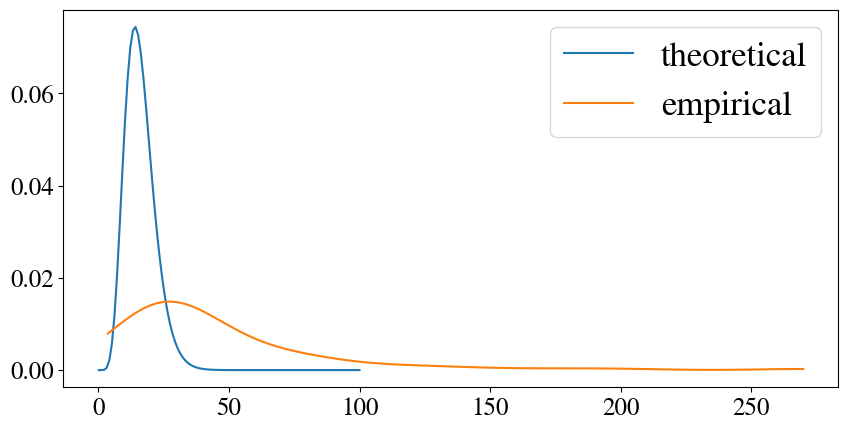

In [113]:
def _filtered_outliers(vec):
    vec = np.array(vec)
    Q1, Q3 = np.quantile(vec, [0.25, 0.75])
    IQR = Q3-Q1
    lb, ub = Q1-1.5*IQR, Q3+1.5*IQR
    #vec_filtered = vec[(vec>0) & (vec<30)]
    vec_filtered = vec[(vec>lb) & (vec<ub)]
    vec_filtered = vec
    return vec_filtered

from scipy.stats import chi2
T_vs_new = _filtered_outliers(T_vs)
#T_vs_new = np.array(T_vs)
chi_df = paras.r*paras.N
xs = np.linspace(0.1, 100, 100)
theo_curvs_log = chi2.logpdf(xs, chi_df);
plt.plot(xs, np.exp(theo_curvs_log) , label="theoretical")
_plot_kde(T_vs_new, label="empirical")
#_plot_kde(np.array(T_vs), label="empirical")
plt.legend()

In [114]:
CV = chi2.ppf(0.95, chi_df)
np.mean(T_vs_new>CV)

0.62

In [115]:
np.mean(T_vs_new),  T_vs_new.shape

(44.755967308679494, (100,))

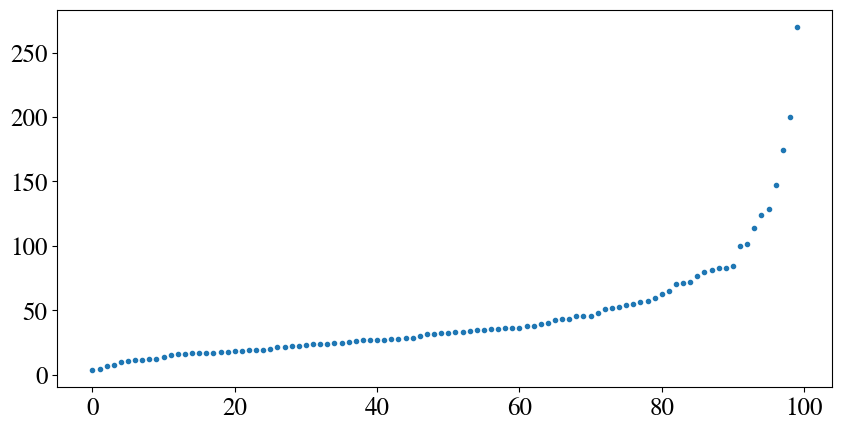

In [116]:
plt.plot(np.sort(T_vs), ".")